In [13]:
%matplotlib inline
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import kagglehub
import keras
from keras import layers
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint
# Download latest version
path = kagglehub.dataset_download("orvile/ravdess-dataset")

print("Path to dataset files:", path)

filepaths = []
labels = []
emotions = {
    "01": 0,  # neutral
    "02": 1,  # calm
    "03": 2,  # happy
    "04": 3,  # sad
    "05": 4,  # angry
    "06": 5,  # fearful
    "07": 6,  # disgust
    "08": 7   # surprised
}


Path to dataset files: C:\Users\Dell\.cache\kagglehub\datasets\orvile\ravdess-dataset\versions\1


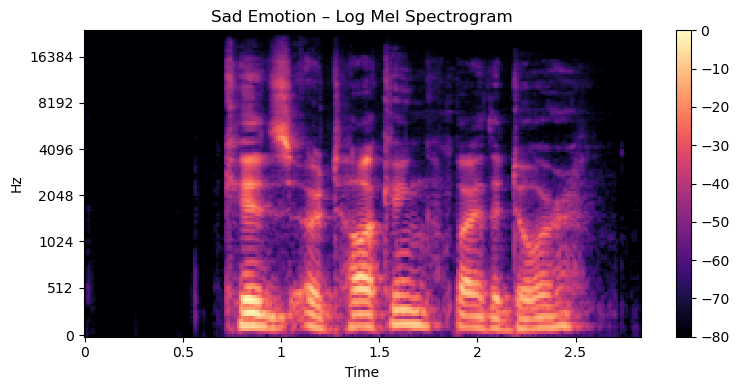

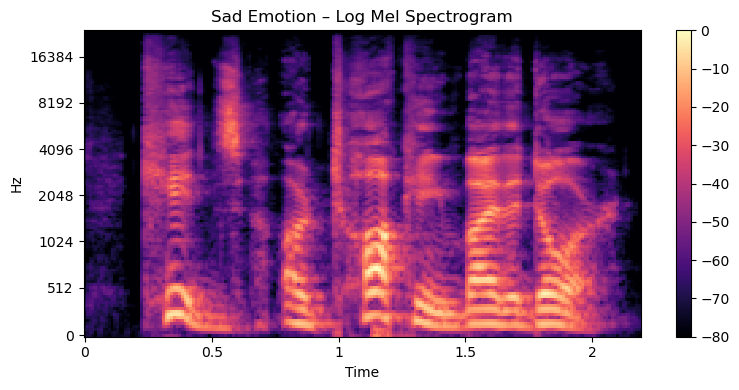

In [2]:
# Sad spectrogram
audio_path = os.path.join(
    path, "Audio_Speech_Actors_01-24\Actor_01", "03-01-04-01-01-01-01.wav"
)
y, sr = librosa.load(audio_path, sr=None)
yt, _ = librosa.effects.trim(y)

mel = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=128)
log_mel = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(8, 4))
librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title("Sad Emotion – Log Mel Spectrogram")
plt.tight_layout()
plt.show()

# Angry spectogram
audio_path = os.path.join(
    path, "Audio_Speech_Actors_01-24\Actor_01", "03-01-05-01-01-01-01.wav"
)
y, sr = librosa.load(audio_path, sr=None)
yt, _ = librosa.effects.trim(y)

mel = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=128)
log_mel = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(8, 4))
librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title("Sad Emotion – Log Mel Spectrogram")
plt.tight_layout()
plt.show()





In [3]:
#Gets path of each files and stores it in a dataframe with file and emotion corresponding to each other
for root, _, files in os.walk(path):
    for file in files:
        if file.endswith(".wav"):
            fpath = os.path.join(root, file)
            filepaths.append(fpath)

            # Extract emotion from filename
            emotion = int(file.split("-")[2]) - 1  # 0–7
            labels.append(emotion)

df = pd.DataFrame({
    "path": filepaths,
    "emotion": labels
})

#Padding function to bring all the files to a uniform time frame number
def pad_spectrogram(spec, max_len):
    if spec.shape[1] < max_len:
        pad_width = max_len - spec.shape[1]
        spec = np.pad(
            spec,
            pad_width=((0, 0), (0, pad_width)),
            mode="constant"
        )
    else:
        spec = spec[:, :max_len]

    return spec
    
#Creating a function which saves a log mel spectrogram for each of the audio file after trimming
def create_mel(y,sr,n_mels=128):    #silence trimming
    yt,index = librosa.effects.trim(y)
    #creating log mel spectogram
    mel_spec = librosa.feature.melspectrogram(
        y=yt,
        sr=sr,
        n_mels=n_mels,
        
    )
    log_mel_spec = librosa.power_to_db(
        mel_spec,
        ref=np.max
    )

    return log_mel_spec


X = []
y = []

for idx, row in df.iterrows():
    # Load 
    y_audio, _ = librosa.load(row["path"], sr=22050)
    # Extract log-Mel Spectrograms and put them in the dataset array with spectogram and emotion as X and Y
    spec = create_mel(
        y_audio,
        sr=22050,
        n_mels=128
    )

    # Padding each spectrogram
    spec = pad_spectrogram(spec, max_len=175)

    X.append(spec)
    y.append(row["emotion"])

#saves each spectrogram and its emotion in the numpy arrays
X = np.array(X)
y = np.array(y)
np.save("X.npy", X)
np.save("y.npy", y)

In [4]:
model = keras.Sequential([
                         Conv2D(input_shape=(128,175,1),filters=64,kernel_size=(3,3)),
                         BatchNormalization(),
                         Activation("relu"),
                         MaxPooling2D(2,2),

                         Conv2D(128, (3,3),),
                         BatchNormalization(),
                         Activation("relu"),
                         MaxPooling2D((2,2)),
                         Dropout(0.25),

                         GlobalAveragePooling2D(),
                         Flatten(),
                         Dense(8,activation="softmax")
                         ])
model.add(Dropout(0.15))
model.summary()

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 173, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 173, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 173, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 84, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 61, 84, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,296 (298.03 KB)

 Trainable params: 75,912 (296.53 KB)

 Non-trainable params: 384 (1.50 KB)

In [10]:
df["emotion_id"] = df["emotion"].map(emotions)
X = np.load("X.npy")   # (samples, 128, 175)
y = np.load("y.npy")   # (samples,)

#Performs a striation split into test,train and val ratio given in the problem statement 
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

df_train, df_temp = train_test_split(
    df,
    test_size=0.2,
    stratify=df["emotion"],
    random_state=42
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["emotion"],
    random_state=42
)

#A function to get the gender of the speaker from the path of the audio file name
def get_gender_from_path(path):
    actor_id = int(path.split("-")[-1].split(".")[0])
    return "male" if actor_id <= 12 else "female"

df_test["gender"] = df_test["path"].apply(get_gender_from_path)

#Normalizes and standardizes all the files being used for training and testing, after that adds an extra channel dimension which is req for processing further
mean = np.mean(X_train)
std = np.std(X_train) + 1e-8

X_train = (X_train - mean) / std
X_val   = (X_val   - mean) / std
X_test  = (X_test  - mean) / std

X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

num_classes = 8
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val   = tf.keras.utils.to_categorical(y_val, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)


print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (1961, 128, 175, 1) (1961, 8)
Val:   (245, 128, 175, 1) (245, 8)
Test:  (246, 128, 175, 1) (246, 8)


In [ ]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
#performs this split as the audio augmentation is yet to be done before training
train_paths, temp_paths, y_train_raw, y_temp_raw = train_test_split(
    df["path"].values,
    df["emotion"].values,
    test_size=0.2,
    stratify=df["emotion"].values
)

def augment_audio(y, sr):
    # Pitch shift (small)
    y_aug = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    #noise injection
    noise = 0.005 * np.random.randn(len(y_aug))
    y_aug = y_aug + noise

    return y_aug

X_aug = []
y_aug = []

for path, label in zip(train_paths, y_train_raw):
    y_audio, sr = librosa.load(path, sr=22050)
    y_audio, _ = librosa.effects.trim(y_audio)
    # Apply BOTH augmentations
    y_aug_audio = augment_audio(y_audio, sr)

    # Extract spectrogram ONCE
    spec = create_mel(y_aug_audio,sr)
    spec = pad_spectrogram(spec, max_len=175)

    X_aug.append(spec)
    y_aug.append(label)

#Adds the augmented data to the new variables for replacements in the dataset
X_aug = np.array(X_aug)
X_aug = (X_aug - mean) / std
X_aug = X_aug[..., np.newaxis]   # (M, 128, 175, 1)
X_train_aug = np.concatenate([X_train, X_aug], axis=0)
y_train_aug = np.concatenate(
    [np.argmax(y_train, axis=1), np.array(y_aug)]
)
y_train_aug = tf.keras.utils.to_categorical(y_train_aug, 8)

# Replace training data ONLY
X_train = X_train_aug
y_train = y_train_aug

checkpoint = ModelCheckpoint(
    "best_emotion_model.keras",   # output file
    monitor="val_loss",           # criterion for "best"
    save_best_only=True,          # only save when val_loss improves
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint],
    verbose=1
)
#Keeps the best model with the minimum valuation loss for saving weights
model = tf.keras.models.load_model("best_emotion_model.keras")

#Training model(also used in evaluation gender bias)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_train_int = np.argmax(y_train, axis=1)
male_idx = df_test["gender"].values == "male"
female_idx = df_test["gender"].values == "female"

y_true_male = y_true[male_idx]
y_pred_male = y_pred[male_idx]

y_true_female = y_true[female_idx]
y_pred_female = y_pred[female_idx]
print(np.unique(y_train_int, return_counts=True))
macro_f1 = f1_score(y_true, y_pred, average="macro")
print("Macro F1:", macro_f1)
print(np.unique(y_pred, return_counts=True))


In [14]:

male_f1 = f1_score(y_true_male, y_pred_male, average="macro")
female_f1 = f1_score(y_true_female, y_pred_female, average="macro")

male_acc = accuracy_score(y_true_male, y_pred_male)
female_acc = accuracy_score(y_true_female, y_pred_female)

print("Male   → Accuracy:", male_acc, "Macro F1:", male_f1)
print("Female → Accuracy:", female_acc, "Macro F1:", female_f1)

Male   → Accuracy: 0.3728813559322034 Macro F1: 0.3624246705071822
Female → Accuracy: 0.40625 Macro F1: 0.3753728210730111


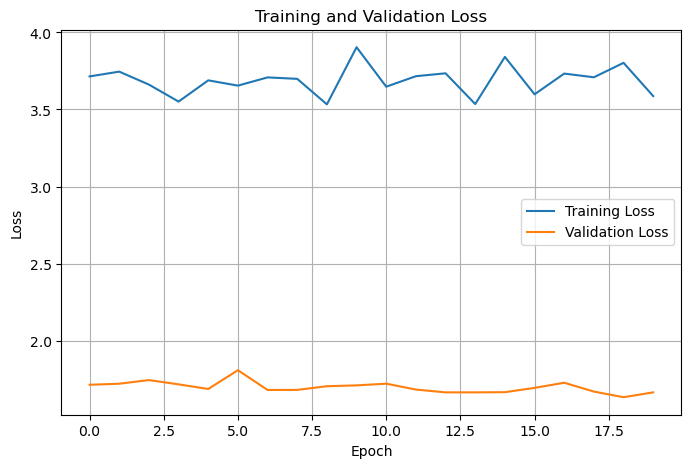

[[ 0  7  6  5  0  1  0  0]
 [ 0 14  5 17  1  0  1  0]
 [ 0  1 10 12  8  3  1  2]
 [ 0 10  4 17  2  3  2  0]
 [ 0  0  7  1 22  2  2  4]
 [ 0  0  4  4 11 13  2  4]
 [ 0  0  0  2  7  0  7  3]
 [ 0  0  1  0  2  1  2 13]]


In [15]:
model = tf.keras.models.load_model("best_emotion_model.keras")
#Plots the training curves
plt.figure(figsize=(8, 5))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

cm = confusion_matrix(y_true, y_pred)
print(cm)

In [17]:
!python predict.py test_audio.wav


1/1 ==================== 0s 196ms/step
1/1 ==================== 0s 221ms/step
Predicted Emotion: Calm
Confidence: 25.69%


2026-02-07 12:54:22.737356: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-07 12:54:25.955830: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-07 12:54:29.833749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
